In [2]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from keras.layers import Lambda, Input, GaussianNoise,concatenate, Dense, Dropout, Conv2D, Add, UpSampling2D, Dot, Conv2DTranspose, Activation, Reshape, InputSpec, LeakyReLU, Flatten, BatchNormalization, SpectralNormalization, GlobalAveragePooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D, Conv2D, Conv3D, Conv2DTranspose, Embedding
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath("../.."))
from src.preprocessing.preprocessing_functions import *
from sklearn.utils.class_weight import compute_class_weight
from keras.applications import VGG19, VGG16


In [3]:
x_train = np.load('/Users/inescunha/Documents/GitHub/AI4CellFate/data/final_split/augmented_x_train.npy')
y_train = np.load('/Users/inescunha/Documents/GitHub/AI4CellFate/data/final_split/augmented_y_train.npy')
x_val = np.load('/Users/inescunha/Documents/GitHub/AI4CellFate/data/final_split/x_val.npy')
y_val = np.load('/Users/inescunha/Documents/GitHub/AI4CellFate/data/final_split/y_val.npy')
x_test = np.load('/Users/inescunha/Documents/GitHub/AI4CellFate/data/final_split/x_test.npy')
y_test = np.load('/Users/inescunha/Documents/GitHub/AI4CellFate/data/final_split/y_test.npy')

In [12]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

num_classes = len(np.unique(y_train))
# Build a new model for your task
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling to flatten feature maps
x = Dense(512, activation='relu')(x)  
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)
# Final model
clf_model = Model(inputs=base_model.input, outputs=outputs)

# Freeze VGG19 layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

tf.keras.utils.set_random_seed(46)

clf_model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.0001, clipvalue=0.5), metrics=["accuracy"])

clf_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,978,370 (57.14 MB)

 Trainable params: 263,682 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [38]:
def process_for_vgg(image): # the input is (20, 20)
    # Pad to make it the minimum size for VGG (32, 32, 3)
    image = np.expand_dims(image, axis=-1)
    padded_x_train = np.pad(image, ((0, 0), (6, 6), (6, 6), (0, 0)), mode='constant')
    padded_x_train = np.concatenate((padded_x_train, padded_x_train), axis=-1)
    padded_x_train = np.concatenate((padded_x_train, padded_x_train[:,:,:,0:1]), axis=-1)
    return padded_x_train

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.5004 - loss: 0.7628 - val_accuracy: 0.6679 - val_loss: 0.6296
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.5738 - loss: 0.6876 - val_accuracy: 0.6787 - val_loss: 0.5979
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.6088 - loss: 0.6739 - val_accuracy: 0.6715 - val_loss: 0.5984
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.6174 - loss: 0.6584 - val_accuracy: 0.6787 - val_loss: 0.5814
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.6259 - loss: 0.6366 - val_accuracy: 0.6679 - val_loss: 0.5838
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.6358 - loss: 0.6286 - val_accuracy: 0.6570 - val_loss: 0.5831
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.6580 - loss: 0.6233 - val_accuracy: 0.6606 - val_loss: 0.5774
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.6650 - loss: 0.6072 - val_accuracy: 0.

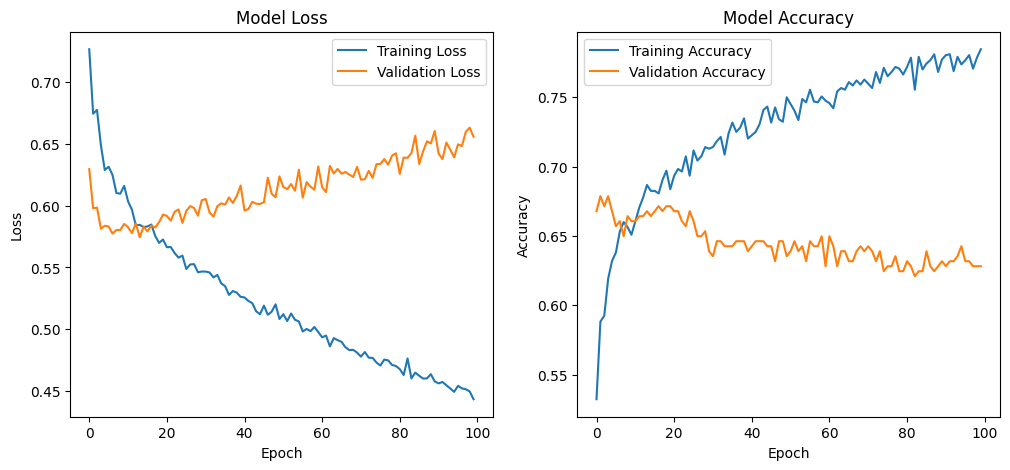

In [39]:
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train.flatten()), y=y_train.flatten())
# class_weights = dict(enumerate(class_weights))

history = clf_model.fit(process_for_vgg(x_train), y_train, batch_size=32, epochs=100, validation_data=(process_for_vgg(x_val), y_val))

plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
[[0.67672414 0.32327586]
 [0.42222222 0.57777778]]


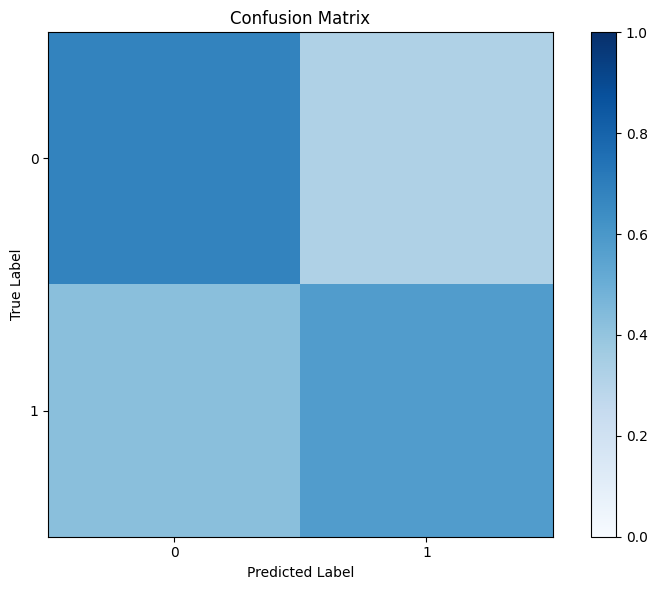

In [41]:
num_classes = len(np.unique(y_train))
y_pred = clf_model.predict(process_for_vgg(x_test))
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [ ]:
# np.save("imagenet_conf_matrix_seed46.npy", conf_matrix_normalized)

## Loading all 3 trained models confusion matrices

In [4]:
imagenet_seed42 = np.load("imagenet_conf_matrix_seed42.npy")
imagenet_seed44 = np.load("imagenet_conf_matrix_seed44.npy")
imagenet_seed46 = np.load("imagenet_conf_matrix_seed46.npy")

ai4cellfate_seed42 = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/results/s1_ep35_lr5_la1_seed42_ldim2_s2_lr6_la4_lc1_lcon8/confusion_matrix_values_epoch_52.npy")
ai4cellfate_seed44 = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/results/s1_ep35_lr5_la1_seed48_ldim2_s2_lr6_la4_lc1_lcon8/confusion_matrix_values_epoch_53.npy")
ai4cellfate_seed46 = np.load("/Users/inescunha/Documents/GitHub/AI4CellFate/results/s1_ep35_lr5_la1_seed46_ldim2_s2_lr6_la4_lc1_lcon8/confusion_matrix_values_epoch_50.npy")

conf_matrix_imagenet = np.stack([imagenet_seed42, imagenet_seed44, imagenet_seed46], axis=0)
conf_matrix_ai4cellfate = np.stack([ai4cellfate_seed42, ai4cellfate_seed44, ai4cellfate_seed46], axis=0)

In [5]:
conf_matrix_ai4cellfate

array([[[0.75431034, 0.24568966],
        [0.31111111, 0.68888889]],

       [[0.68103448, 0.31896552],
        [0.24444444, 0.75555556]],

       [[0.71551724, 0.28448276],
        [0.28888889, 0.71111111]]])

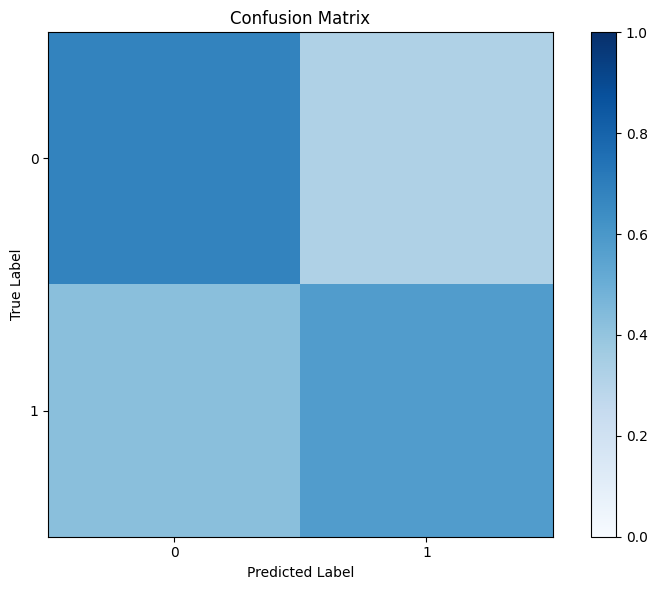

In [13]:
mean_conf_matrix_imagenet = np.mean(conf_matrix_imagenet,axis=0)

plt.figure(figsize=(8, 6))
plt.imshow(mean_conf_matrix_imagenet, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

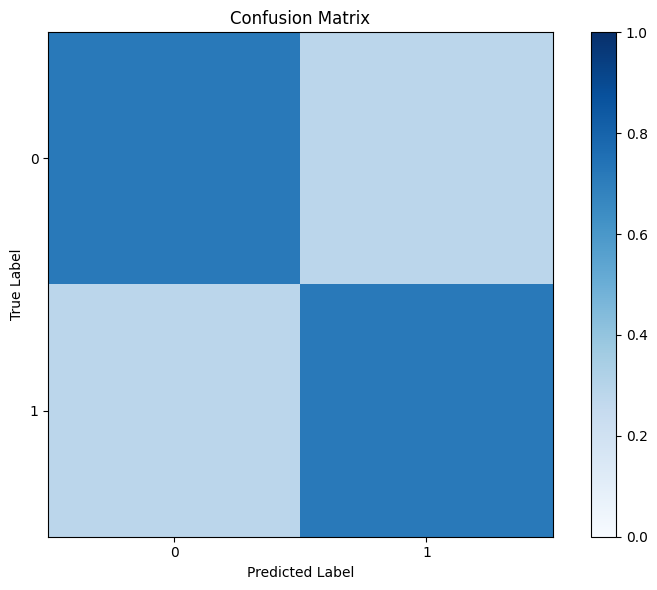

In [14]:
mean_conf_matrix_ai4cellfate = np.mean(conf_matrix_ai4cellfate,axis=0)

plt.figure(figsize=(8, 6))
plt.imshow(mean_conf_matrix_ai4cellfate, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [16]:
# Compute precision (class 0) and accuracy (mean diagonal) for both models across seeds
import numpy as np

# Expect these to be defined from previous cells:
# conf_matrix_imagenet: shape (3, 2, 2)
# conf_matrix_ai4cellfate: shape (3, 2, 2)

assert 'conf_matrix_imagenet' in globals(), 'conf_matrix_imagenet not found.'
assert 'conf_matrix_ai4cellfate' in globals(), 'conf_matrix_ai4cellfate not found.'

# Functions consistent with earlier definition (using normalized confusion matrices)
def compute_metrics_from_cm(cm_norm):
    # Accuracy as mean diagonal
    acc = float(np.mean(np.diag(cm_norm)))
    # Precision for class 0 (per prior convention)
    denom = (cm_norm[0, 0] + cm_norm[1, 0])
    prec = float(cm_norm[0, 0] / denom) if denom > 0 else np.nan
    return acc, prec

# Per-seed arrays
acc_imagenet = []
prec_imagenet = []
acc_ai4cf = []
prec_ai4cf = []

for i in range(conf_matrix_imagenet.shape[0]):
    a, p = compute_metrics_from_cm(conf_matrix_imagenet[i])
    acc_imagenet.append(a)
    prec_imagenet.append(p)

for i in range(conf_matrix_ai4cellfate.shape[0]):
    a, p = compute_metrics_from_cm(conf_matrix_ai4cellfate[i])
    acc_ai4cf.append(a)
    prec_ai4cf.append(p)

acc_imagenet = np.array(acc_imagenet)
prec_imagenet = np.array(prec_imagenet)
acc_ai4cf = np.array(acc_ai4cf)
prec_ai4cf = np.array(prec_ai4cf)

# Means and STDs for bar plot
accuracy_imagenet_mean = float(np.nanmean(acc_imagenet))
accuracy_imagenet_std = float(np.nanstd(acc_imagenet))
precision_imagenet_mean = float(np.nanmean(prec_imagenet))
precision_imagenet_std = float(np.nanstd(prec_imagenet))

accuracy_ai4cellfate_mean = float(np.nanmean(acc_ai4cf))
accuracy_ai4cellfate_std = float(np.nanstd(acc_ai4cf))
precision_ai4cellfate_mean = float(np.nanmean(prec_ai4cf))
precision_ai4cellfate_std = float(np.nanstd(prec_ai4cf))

print('ImageNet  - Acc: {:.4f} ± {:.4f}, Prec0: {:.4f} ± {:.4f}'.format(
    accuracy_imagenet_mean, accuracy_imagenet_std, precision_imagenet_mean, precision_imagenet_std))
print('AI4CellFate - Acc: {:.4f} ± {:.4f}, Prec0: {:.4f} ± {:.4f}'.format(
    accuracy_ai4cellfate_mean, accuracy_ai4cellfate_std, precision_ai4cellfate_mean, precision_ai4cellfate_std))

# Bundle for convenient downstream plotting
metrics_summary = {
    'imagenet': {
        'accuracy': {'mean': accuracy_imagenet_mean, 'std': accuracy_imagenet_std, 'per_seed': acc_imagenet},
        'precision_class0': {'mean': precision_imagenet_mean, 'std': precision_imagenet_std, 'per_seed': prec_imagenet},
    },
    'ai4cellfate': {
        'accuracy': {'mean': accuracy_ai4cellfate_mean, 'std': accuracy_ai4cellfate_std, 'per_seed': acc_ai4cf},
        'precision_class0': {'mean': precision_ai4cellfate_mean, 'std': precision_ai4cellfate_std, 'per_seed': prec_ai4cf},
    }
}

# Example arrays ready for bar plot cell
bar_models = ['ImageNet', 'AI4CellFate']
bar_accuracy_means = [accuracy_imagenet_mean, accuracy_ai4cellfate_mean]
bar_accuracy_stds = [accuracy_imagenet_std, accuracy_ai4cellfate_std]
bar_precision_means = [precision_imagenet_mean, precision_ai4cellfate_mean]
bar_precision_stds = [precision_imagenet_std, precision_ai4cellfate_std]


ImageNet  - Acc: 0.6280 ± 0.0147, Prec0: 0.6159 ± 0.0064
AI4CellFate - Acc: 0.7177 ± 0.0034, Prec0: 0.7187 ± 0.0122


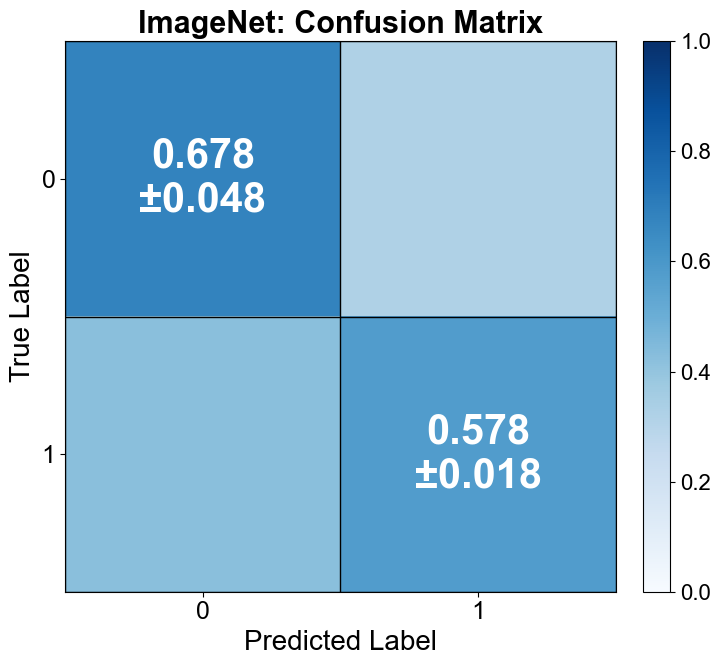

In [ ]:
# Annotated mean confusion matrix with ± std (across 3 seeds)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Ensure required arrays exist: conf_matrix_imagenet (3,2,2)
assert 'conf_matrix_imagenet' in globals(), 'conf_matrix_imagenet not found.'

# Compute mean and std across seeds
mean_cm = np.mean(conf_matrix_imagenet, axis=0)
std_cm = np.std(conf_matrix_imagenet, axis=0)

# Use Arial and larger fonts
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 18

fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(mean_cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)

# Title and labels
ax.set_title('ImageNet: Confusion Matrix', fontsize=22, fontweight='bold')
num_classes = mean_cm.shape[0]
ax.set_xlabel('Predicted Label', fontsize=20)
ax.set_ylabel('True Label', fontsize=20)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels([str(i) for i in range(num_classes)], fontsize=18)
ax.set_yticklabels([str(i) for i in range(num_classes)], fontsize=18)

# Grid lines for clarity
ax.set_xticks(np.arange(-0.5, num_classes, 1), minor=True)
ax.set_yticks(np.arange(-0.5, num_classes, 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
ax.tick_params(which='minor', bottom=False, left=False)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=16)

# Annotate each cell with mean ± std
for i in range(num_classes):
    for j in range(num_classes):
        if i == j:  # Only show values on the diagonal
            text = f"{mean_cm[i, j]:.3f}\n±{std_cm[i, j]:.3f}"
            ax.text(j, i, text, ha='center', va='center', color='white', fontsize=30, fontweight='bold')

plt.tight_layout()
#plt.savefig("imagenet_conf_matrix.eps", dpi=300, bbox_inches="tight")
plt.show()


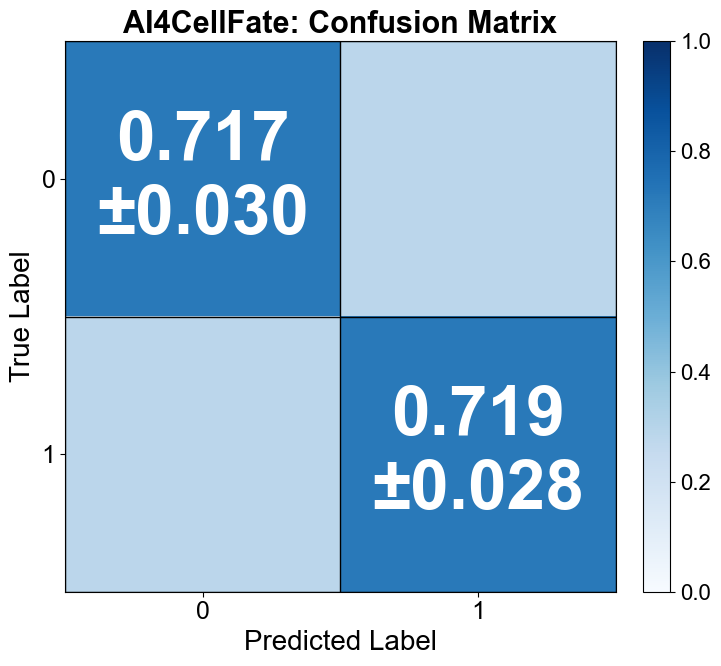

In [ ]:
# Annotated mean confusion matrix with ± std (across 3 seeds)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Compute mean and std across seeds
mean_cm = np.mean(conf_matrix_ai4cellfate, axis=0)
std_cm = np.std(conf_matrix_ai4cellfate, axis=0)

# Use Arial and larger fonts
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 18

fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(mean_cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)

# Title and labels
ax.set_title('AI4CellFate: Confusion Matrix', fontsize=22, fontweight='bold')
num_classes = mean_cm.shape[0]
ax.set_xlabel('Predicted Label', fontsize=20)
ax.set_ylabel('True Label', fontsize=20)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels([str(i) for i in range(num_classes)], fontsize=18)
ax.set_yticklabels([str(i) for i in range(num_classes)], fontsize=18)

# Grid lines for clarity
ax.set_xticks(np.arange(-0.5, num_classes, 1), minor=True)
ax.set_yticks(np.arange(-0.5, num_classes, 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
ax.tick_params(which='minor', bottom=False, left=False)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=16)

# Annotate ONLY diagonal cells with mean ± std in WHITE
for i in range(num_classes):
    for j in range(num_classes):
        if i == j:  # Only show values on the diagonal
            text = f"{mean_cm[i, j]:.3f}\n±{std_cm[i, j]:.3f}"
            ax.text(j, i, text, ha='center', va='center', color='white', fontsize=50, fontweight='bold')

plt.tight_layout()
#plt.savefig("ai4cellfate_conf_matrix.eps", dpi=300, bbox_inches="tight")
plt.show()

/var/folders/ds/_m8m03r135b5r67hc6xgtxt00000gn/T/ipykernel_31255/1067469921.py:37: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_patches = [plt.Rectangle((0,0),1,1, color=color, edgecolor='black') for color in legend_colors]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


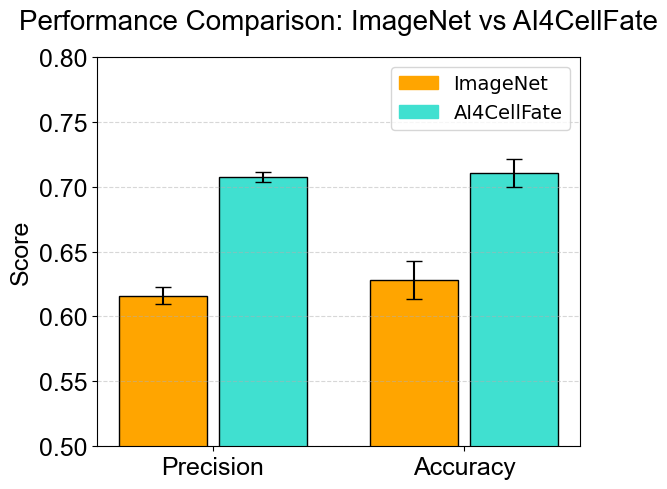

In [ ]:
# Compute means and standard deviations
means_precision = bar_precision_means
std_precision = bar_precision_stds
means_accuracy = bar_accuracy_means
std_accuracy = bar_accuracy_stds

# X positions for bars (closer together)
x = np.array([0, 0.8])  # Precision bars
x2 = x + 2.0  # Accuracy bars (closer spacing)

# Plot
fig, ax = plt.subplots(figsize=(6, 5))

# Define bar width
bar_width = 0.7

# Bar plots with error bars
ax.bar(x, means_precision, yerr=std_precision, capsize=6, color=["orange", "turquoise"], edgecolor='black', width=bar_width, label="Precision")
ax.bar(x2, means_accuracy, yerr=std_accuracy, capsize=6, color=["orange", "turquoise"], edgecolor='black', width=bar_width, label="Accuracy")

# X-axis labels centered
ax.set_xticks([0.4, 2.4])  
ax.set_xticklabels(["Precision", "Accuracy"], fontsize=16, fontname='Arial')

# Y-axis label
ax.set_ylabel("Score", fontsize=18, fontname='Arial')

# Y-axis ticks (bigger font)
ax.tick_params(axis='y', labelsize=18)

# Title with extra spacing
ax.set_title("Performance Comparison: ImageNet vs AI4CellFate", fontsize=20, fontname='Arial', pad=20)

# Legend (top right with correct colors)
legend_labels = ["ImageNet", "AI4CellFate"]
legend_colors = ["orange", "turquoise"]
legend_patches = [plt.Rectangle((0,0),1,1, color=color, edgecolor='black') for color in legend_colors]
ax.legend(legend_patches, legend_labels, loc="upper right", fontsize=14)

# Set y-axis limit
ax.set_ylim(0.5, 0.8)

plt.xticks(fontsize=18, fontname="Arial")
plt.yticks(fontsize=18, fontname="Arial")

# Grid
ax.yaxis.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
#plt.savefig("imagenet_ai4cellfate_comparison.eps", dpi=300, bbox_inches="tight")
plt.show()